# Visualizing WhatsApp Chats

### Importing Modules:
* re - for using regex expressions
* pandas - for exploiting dataframes
* matplotlib - for visualization (inline for ploting dataframes)

In [212]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Exported chats
Export WhatsApp chats as follows:
* Navigate to contact/group you want to export chat of
* Tap on the menu (3dots in the right corner)
* Tap on more and then tap on Export chat
* Choose WITHOUT MEDIA from the prompt
* Wait for a moment on the Initializing screen
* Share through mail or any other means
* Gather the exported text file

The text file should have a name as: WhatsApp Chat with ... .txt. Use the same below in the filename variable

In [213]:
is_ios = False

In [214]:
filename = './chats/WhatsApp Chat with Kinjal Raykarmakar.txt'
file = open(filename, 'r', encoding="utf8")

In [215]:
raw_data = file.read().splitlines()
file.close()
# print(raw_data)

#### Regex
Regex for catching the header expression:

12/14/18, 1:28 PM - Person 1: Hello!

(date), (12-hour-time) - (sender-name): (Message)

In [216]:
# android
header_regex = re.compile(r'(\d+\/\d+\/\d+)(,)(\s)(\d+:\d+)(\s)(\w+)(\s)(-)(\s[^:]+)*(:)(\s)')

if is_ios:
    # ios
    header_regex = re.compile(r'\[(\d+\/\d+\/\d+)(,)(\s)(\d+:\d+:\d+)(\s)(\w+)\](\s[^:]+)*(:)(\s)')
    # print(raw_data[1][:50])
    # mo = header_regex.search(raw_data[1][:50])
    # print(mo)
    # mo.groups()

Breaking the captured regex, throughout the file and storing it in a dictionary

In [217]:
data_dict = {'id': [], 'date': [], 'time': [], 'sender': [], 'msg': []}

i = 0
for m in raw_data:
    mo = header_regex.search(m[:50]) # shorten the search string for faster search
    if mo != None:
        data_dict['id'].append(i)
        i += 1
        date = mo.group(1)
        time = mo.group(4) + mo.group(5) + mo.group(6) # including Meridiem
        sender = mo.group(9)[1:] # ignoring the initial space
        if is_ios:
            sender = mo.group(7)[1:]
        msg = m[len(mo.group(0)):]
        data_dict['date'].append(date)
        data_dict['time'].append(time)
        data_dict['sender'].append(sender)
        data_dict['msg'].append(msg)
    else: # continued msg for a sender
        if(len(data_dict['msg']) != 0):
            data_dict['msg'][-1] += m
            
# print(data_dict)

Converting the dictionary into the main Pandas DataFrame

In [218]:
df = pd.DataFrame(data=data_dict)
df.head()

,id,date,time,sender,msg
0,0,20/07/24,12:47 pm,Kinjal Raykarmakar,"Hello, this is KinjalMeine bhi DTU mein MTech ..."
1,1,20/07/24,3:44 pm,Sarthak,Hey kinjal
2,2,20/07/24,3:44 pm,Sarthak,Aap kaha se ho ?
3,3,20/07/24,3:45 pm,Kinjal Raykarmakar,Mein Kolkata se huuAap kaha se ho?
4,4,20/07/24,3:49 pm,Sarthak,Mai uttrakhand se hu


## Sender List

In [219]:
senders = df['sender'].unique().tolist()
print(senders)

['Kinjal Raykarmakar', 'Sarthak']


In [220]:
# !pip install names

# # using pseudo names to hide the indentidy of the senders
# import names

# pseudo_name_list = set()

# while len(pseudo_name_list) < len(senders):
#     pseudo_name_list.add(names.get_full_name())
    
# pseudo_name_list = list(pseudo_name_list)

# for i in range(len(senders)):
#     df.replace(to_replace=senders[i], value=pseudo_name_list[i], inplace=True)
    
# senders = pseudo_name_list

## Sender Message Count

In [221]:
sender_msg_count = df['sender'].value_counts()
print(sender_msg_count)

sender
Sarthak               475
Kinjal Raykarmakar    470
Name: count, dtype: int64


## Bar Chart showing messages sent by each sender

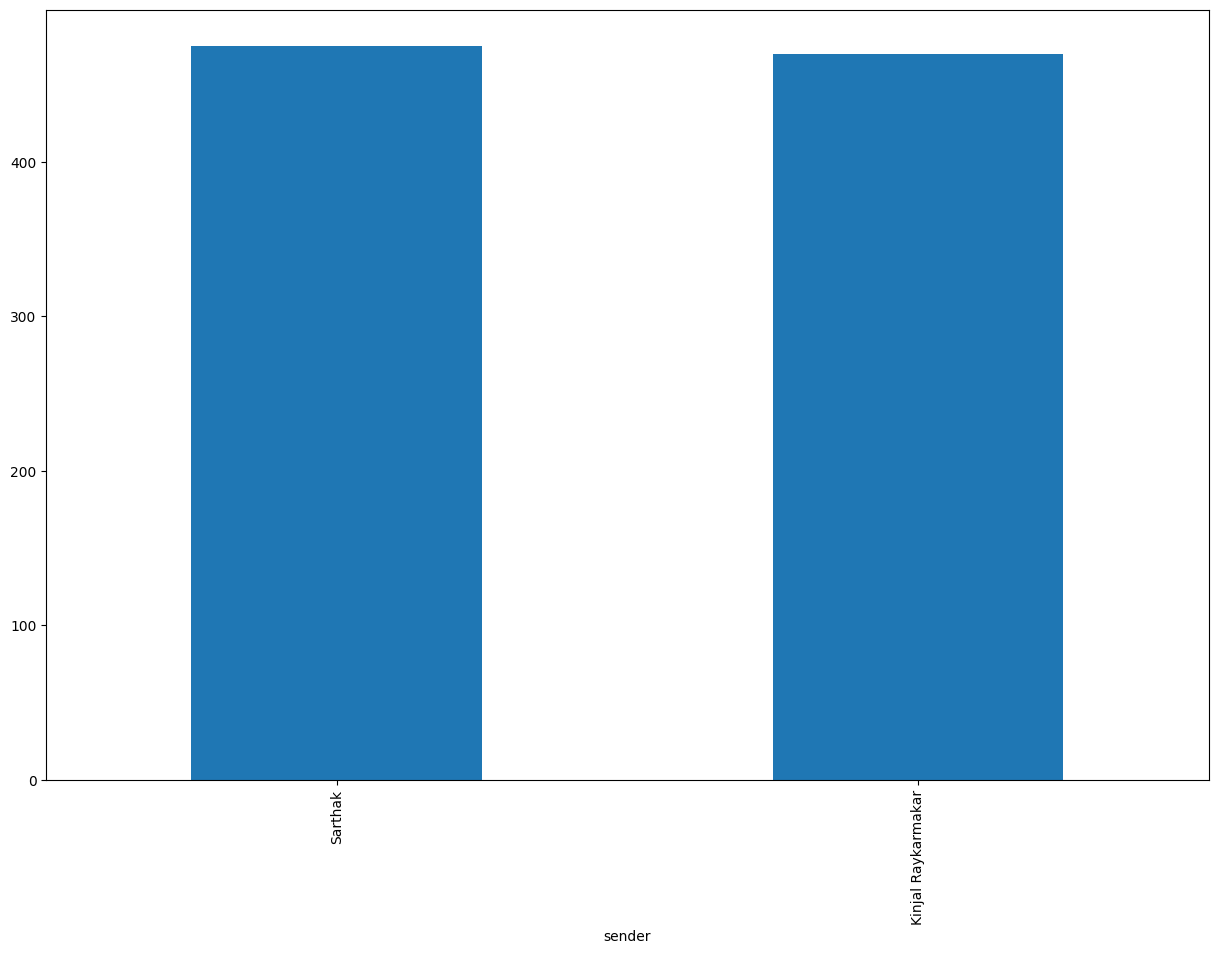

In [222]:
sender_msg_count.plot(kind = 'bar', figsize = (15, 10))
plt.show()

## Pie Chart showing messages sent by each sender

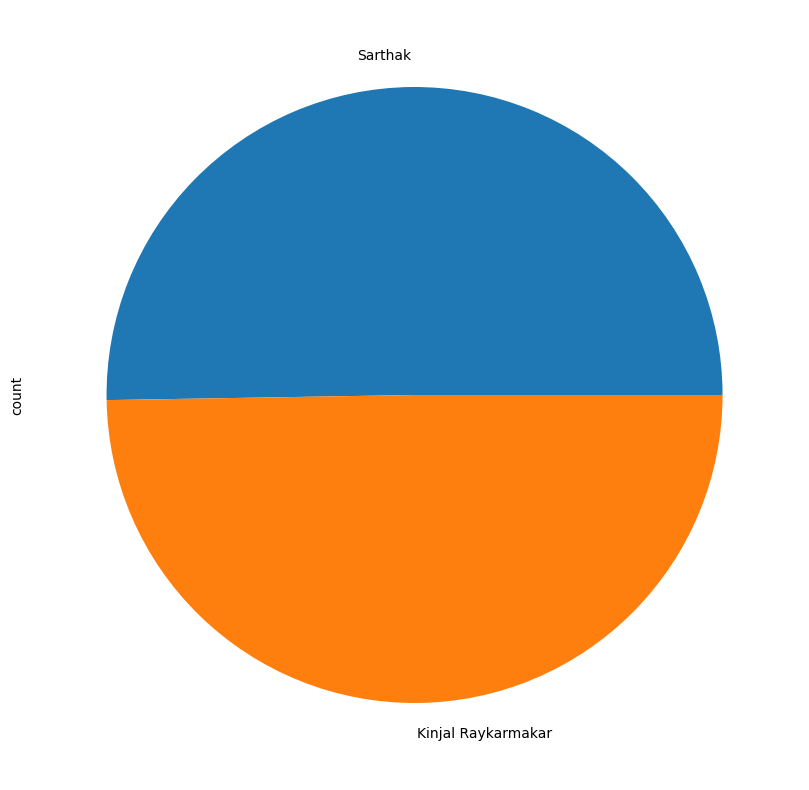

In [223]:
sender_msg_count.plot(kind = 'pie', figsize = (10, 10))
plt.show()

## Bar Chart showing media sent by each sender

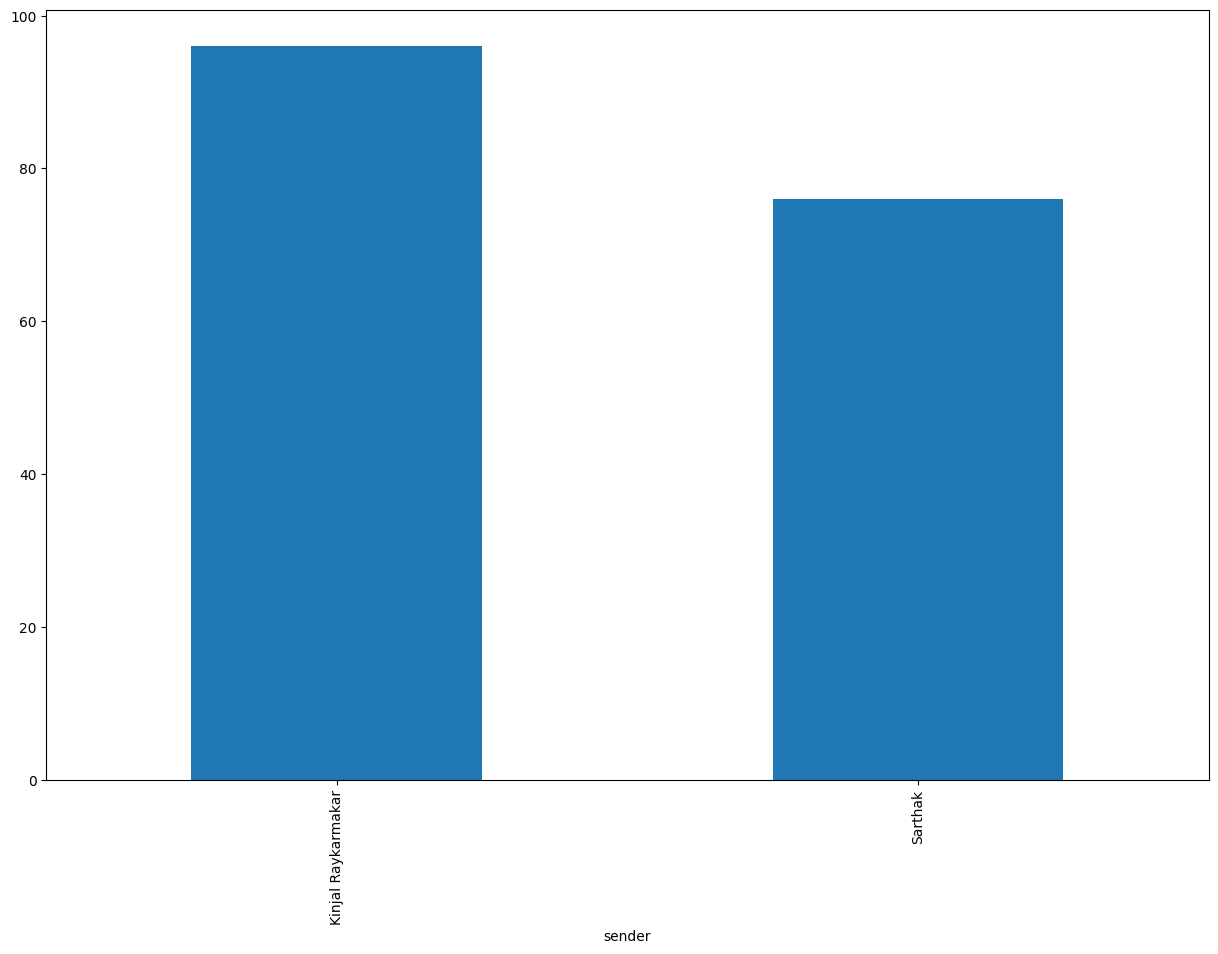

In [224]:
media_msg = df[df['msg'] == '<Media omitted>']
media_msg_count = media_msg['sender'].value_counts()
media_msg_count.plot(kind = 'bar', figsize = (15, 10))
plt.show()

## Pie Chart showing media sent by each sender

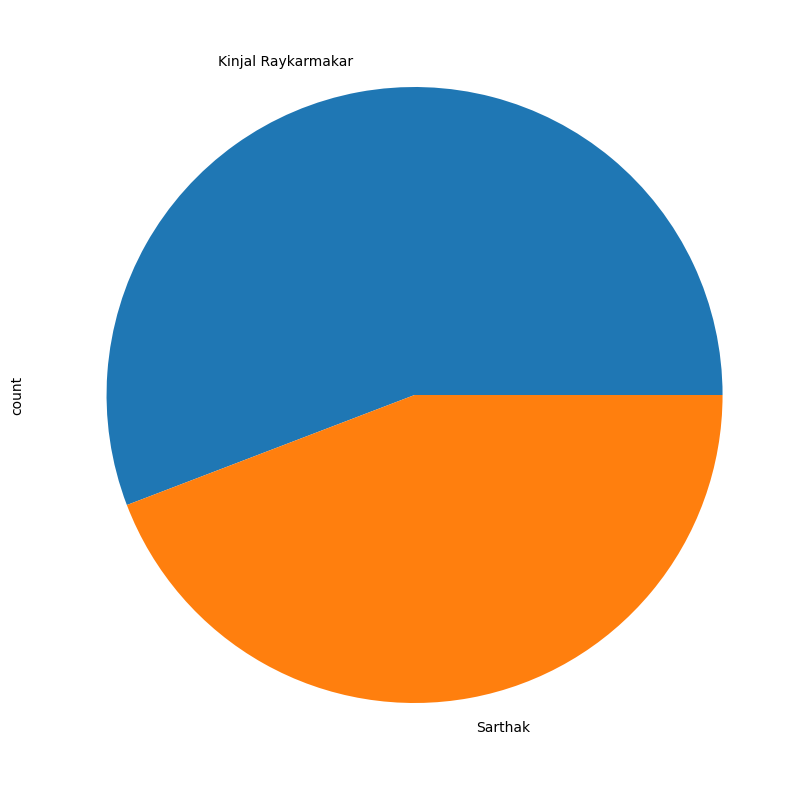

In [225]:
media_msg_count.plot(kind = 'pie', figsize = (10, 10))
plt.show()

## Area Chart showing the total number of messages sent by dates
Days with zero messages are ommited

Calculating the total number of messages datewise, storing it in another Pandas DataFrame

In [226]:
dates = df['date'].unique().tolist() # data list
# print(dates)

temp_dict = {'date': dates, 'msg': []} # no. of msg by date
for d in dates:
    c = 0
    for f in df['date']:
        if d == f:
            c += 1
    temp_dict['msg'].append(c)
    
# print(temp_dict)

datewise_msg_count = pd.DataFrame(data=temp_dict)
# datewise_msg_count.head()

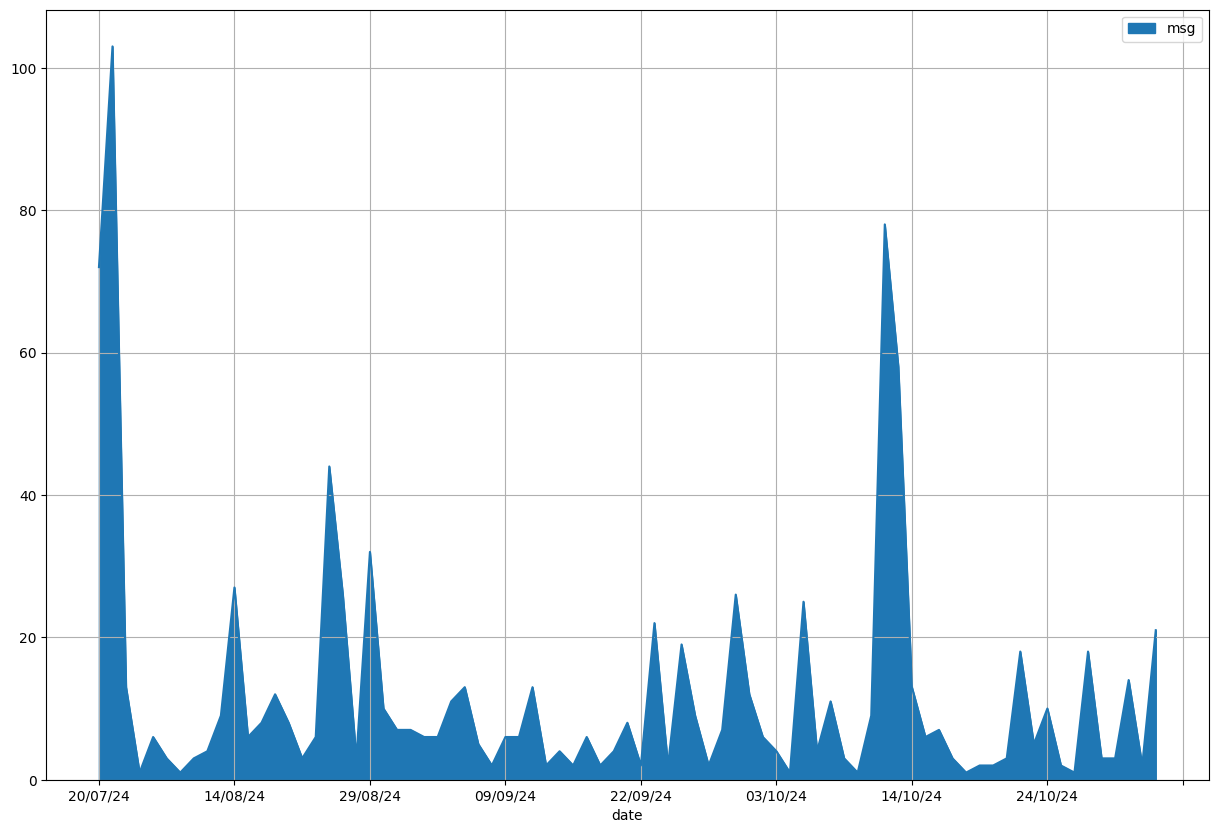

In [227]:
datewise_msg_count.plot(x = 'date', kind = 'area', figsize = (15, 10), grid = True)
plt.show()

## Date on which maximum number of messages were sent

In [228]:
datewise_msg_count.loc[datewise_msg_count['msg'].idxmax()]

date    21/07/24
msg          103
Name: 1, dtype: object

## Date on which minimum number of messages were sent
Days with zero messages are ommited

In [229]:
datewise_msg_count.loc[datewise_msg_count['msg'].idxmin()]

date    23/07/24
msg            1
Name: 3, dtype: object

## Line Chart showing messaging frequency of each sender, datewise, overlapped

Calculating total number of messages sent by each sender on all the dates (senders with zero message in a day are included too)

In [230]:
temp_dict_2 = {'date': dates}
for s in senders:
    temp_dict_2[s] = [] # creating lists for each sender

for s in senders:
    for d in dates:
        date_filter = df['date'] == d # date mask
        sender_filter = df['sender'] == s # sender mask
        c = df['msg'][date_filter & sender_filter].count() # counting occurences of the masked data
        temp_dict_2[s].append(c)
        
# print(temp_dict_2)
senderwise_datewise_msg_count = pd.DataFrame(data=temp_dict_2)
senderwise_datewise_msg_count.head()

,date,Kinjal Raykarmakar,Sarthak
0,20/07/24,29,43
1,21/07/24,27,76
2,22/07/24,6,7
3,23/07/24,1,0
4,04/08/24,3,3


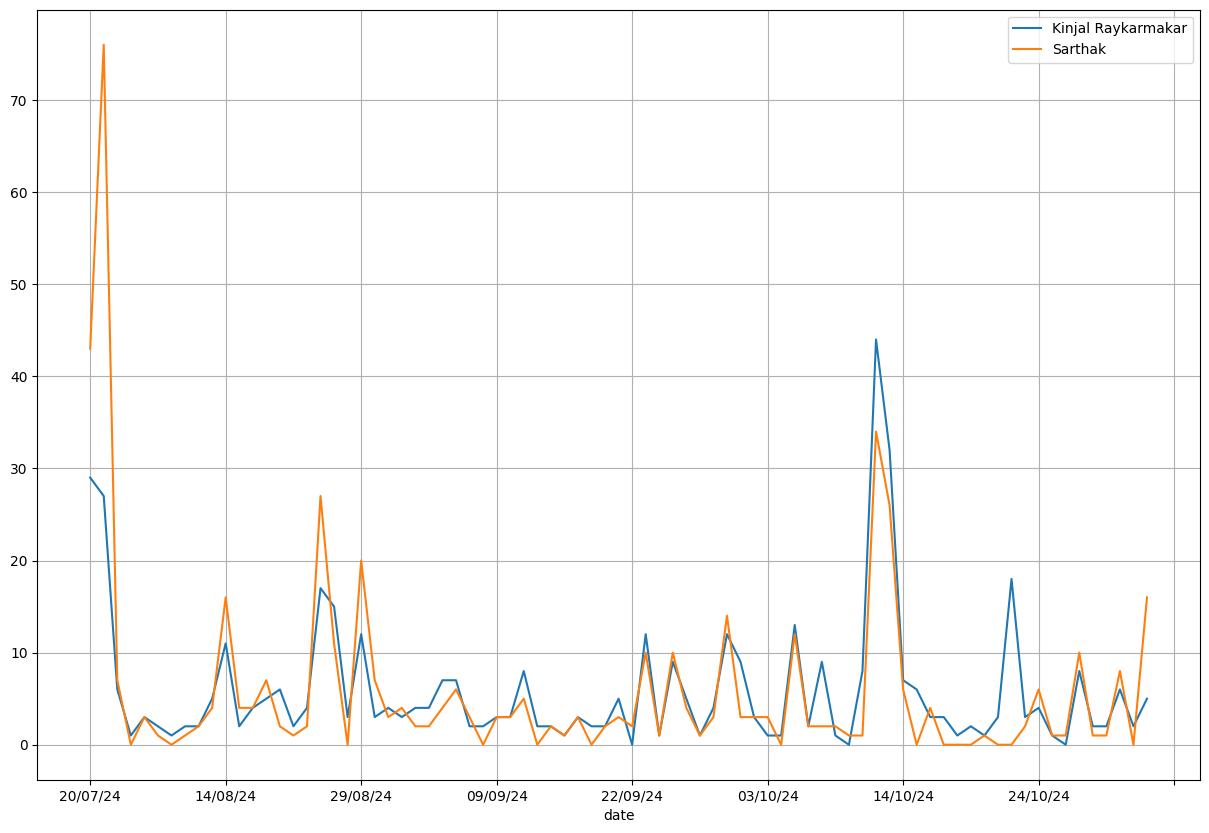

In [231]:
senderwise_datewise_msg_count.plot(x='date', kind = 'line', figsize = (15, 10), grid = True)
plt.show()

## Line Chart showing messaging frequency of each sender, datewise, subplots

In [232]:
# finding maximum message in a day over all senders to set a uniform limit in y axis
max_list = []
for s in senders:
    max_list.append(senderwise_datewise_msg_count[s].max())
    
ymax = max(max_list)


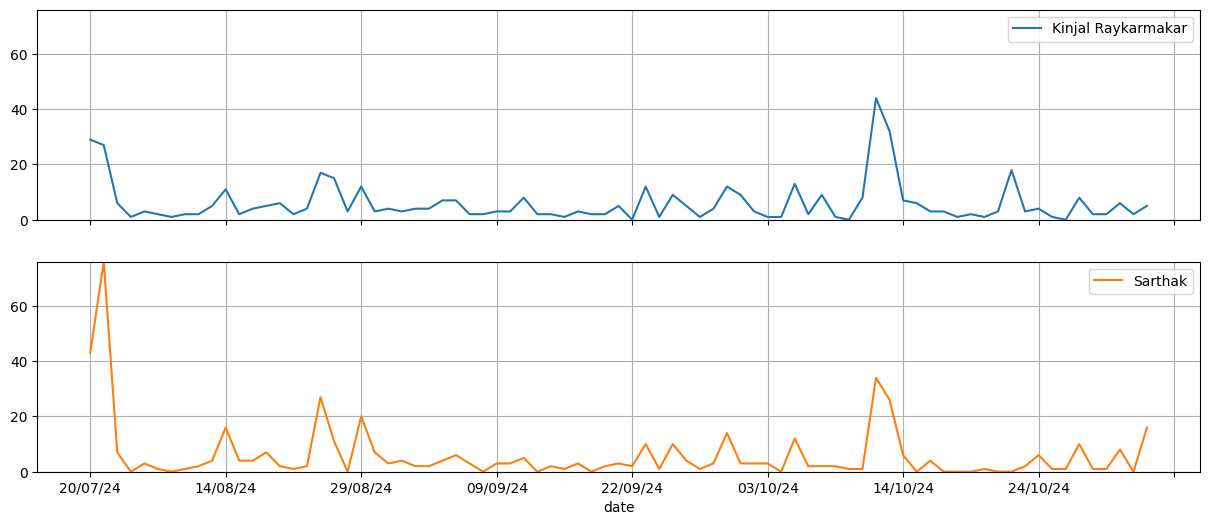

In [233]:
senderwise_datewise_msg_count.plot(x='date', ylim=(0,ymax), kind = 'line', figsize = (15, (3*len(senders))), grid = True, subplots=True)
plt.show()

## Calender Plot showing messaging frequency, datewise

Colours have been normalized between zero and maximum messages in a day (In case of data for multiple years, leading to multiple calender plots for each year)

Year: 24


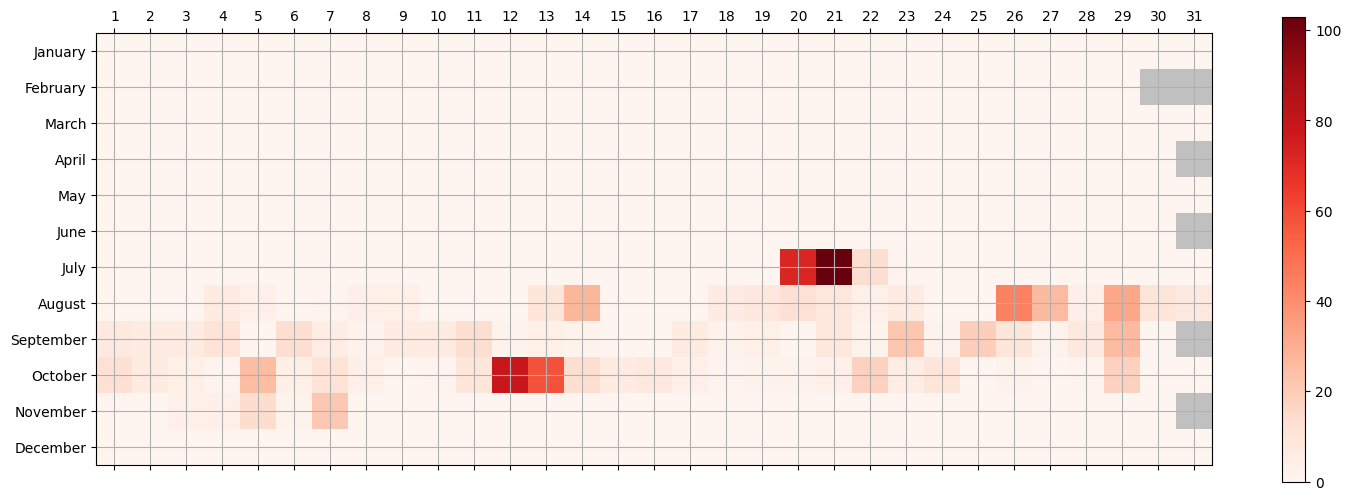

In [234]:
df['date']
date_df = df['date'].str.split('/', n=2, expand = True)
# print(date_df)
max_msg = max(df['date'].value_counts())

calender_mat = np.zeros(shape=(12,31), dtype=float)
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
calender_mat[1][30] = np.nan

for y in date_df[2].unique():
    print("Year:", y)
    year_mask = date_df[2] == y
    for m in date_df[1].unique(): 
        month_mask = date_df[1] == m
        for d in date_df[0].unique():
            day_mask = date_df[0] == d
            calender_mat[int(m)-1][int(d)-1] = date_df[1][year_mask & month_mask & day_mask].count()
    
    year = int(y) + 2000
    if year%4==0 and year%100!=0 or year%400==0:
        month_days[1] = 29
    else:
        month_days[1] = 28

    for i in range(12):
        for j in range(month_days[i], 31):
            calender_mat[i][j] = np.nan
#     print(calender_mat)

    current_cmap = plt.cm.Reds
    current_cmap.set_bad(color='silver')
    
    f = plt.figure(figsize=(18, 6))
#     color_axis = plt.matshow(calender_mat, fignum=f.number, cmap="Reds", vmax=max_msg)
    color_axis = plt.matshow(calender_mat, fignum=f.number, cmap=current_cmap, vmax=max_msg)

    plt.colorbar(color_axis)
    plt.xticks(range(31), range(1, 32))
    plt.yticks(range(12), month_list)    
    
    plt.grid()
    plt.show()

## Datewise Corelation between senders

In [235]:
senderwise_datewise_msg_count_temp = senderwise_datewise_msg_count.drop(columns="date")
corr_df = senderwise_datewise_msg_count_temp.corr().abs()
corr_df.style.background_gradient(cmap='Reds').format(precision=3)

,Kinjal Raykarmakar,Sarthak
Kinjal Raykarmakar,1.000,0.791
Sarthak,0.791,1.000


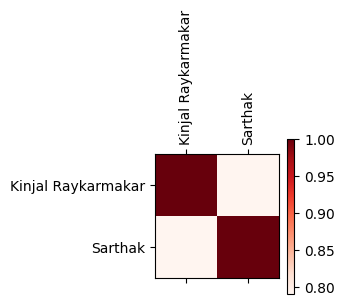

In [236]:
f = plt.figure(figsize=(len(senders), len(senders)))
color_axis = plt.matshow(corr_df, fignum=f.number, cmap="Reds")
plt.colorbar(color_axis)
plt.xticks(range(corr_df.shape[1]), corr_df.columns, rotation=90)
plt.yticks(range(corr_df.shape[1]), corr_df.columns)

plt.show()

In [237]:
# seperating redundant pairs
imposs_pairs = set()
for i in senders:
    for j in senders:
        if (i, j) not in imposs_pairs and (j, i) not in imposs_pairs:
            imposs_pairs.add((i, j))

corr_pair = corr_df.unstack().drop(labels = imposs_pairs).sort_values(ascending=False)
corr_pair

Sarthak  Kinjal Raykarmakar    0.790519
dtype: float64

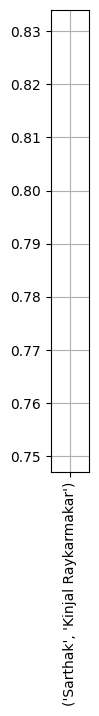

In [238]:
pair_list = list(corr_pair.index)
plt.figure(figsize=(len(pair_list)/2, 6))
corr_pair.plot(grid=True)
plt.xticks(range(len(pair_list)), pair_list, rotation=90)
plt.show()

## Bar Chart showing hourly messaging frequency

Grouping time by 1 hour intervals throughout the day, over all dates

In [239]:
times = [] # hour list(filters only hour from each time)
time_regex = re.compile(r'(\d+):(\d+)(\s)(\w+)')
for t in df['time']:
    mo = time_regex.search(t)
    if mo.group(4) == 'PM' and mo.group(1) == '12':
        times.append(12)
    elif mo.group(4) == 'PM':
        times.append(int(mo.group(1)) + 12)
    elif mo.group(4) == 'AM' and mo.group(1) == '12':
        times.append(0)
    else:
        times.append(int(mo.group(1)))
        
time_dict = {'time': times, 'msg': list(df['msg'])}
time_df = pd.DataFrame(data=time_dict) # contains hour and msg
# print(time_df)

time_count_dict = {'hour': [], 'msg': []} # hour and count of msgs
for i in range(0, 24):
    match = (str(i) + ':')
    time_filter = time_df['time'] == i # hour mask
    time_count_dict['hour'].append(i)
    time_count_dict['msg'].append(time_df['msg'][time_filter].count())

# print(time_count_dict)

time_count_df = pd.DataFrame(data=time_count_dict)
# time_count_df

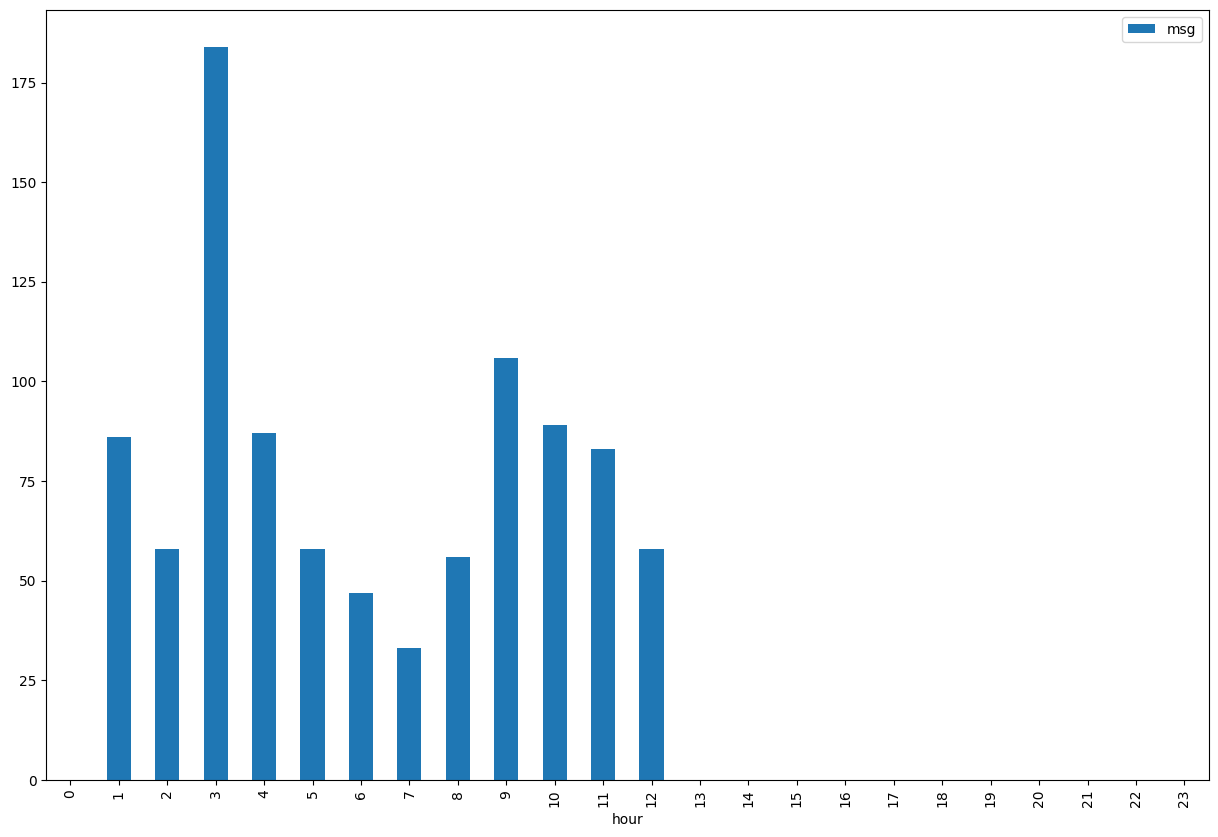

In [240]:
time_count_df.plot(x = 'hour', kind = 'bar', figsize = (15, 10))
plt.show()

## Bar Chart showing hourly messaging frequency, senderwise

In [241]:
time_sender_dict = {'time': times, 'sender':list(df['sender']), 'msg': list(df['msg'])}

time_sender_df = pd.DataFrame(data=time_sender_dict)
time_sender_df

time_count_senderwise_dict = {'hour': list(range(24))}
time_count_senderwise_df = pd.DataFrame(data=time_count_senderwise_dict)

for i in range(0, 24):
    match = (str(i) + ':')
    time_filter = time_sender_df['time'] == i # hour mask
    
    for s in senders:
        sender_filter = time_sender_df['sender'] == s
        if s not in time_count_senderwise_df.columns:
            time_count_senderwise_df[s] = list(range(24))
        count = time_sender_df['msg'][time_filter & sender_filter].count()
        time_count_senderwise_df.at[i, s] = count

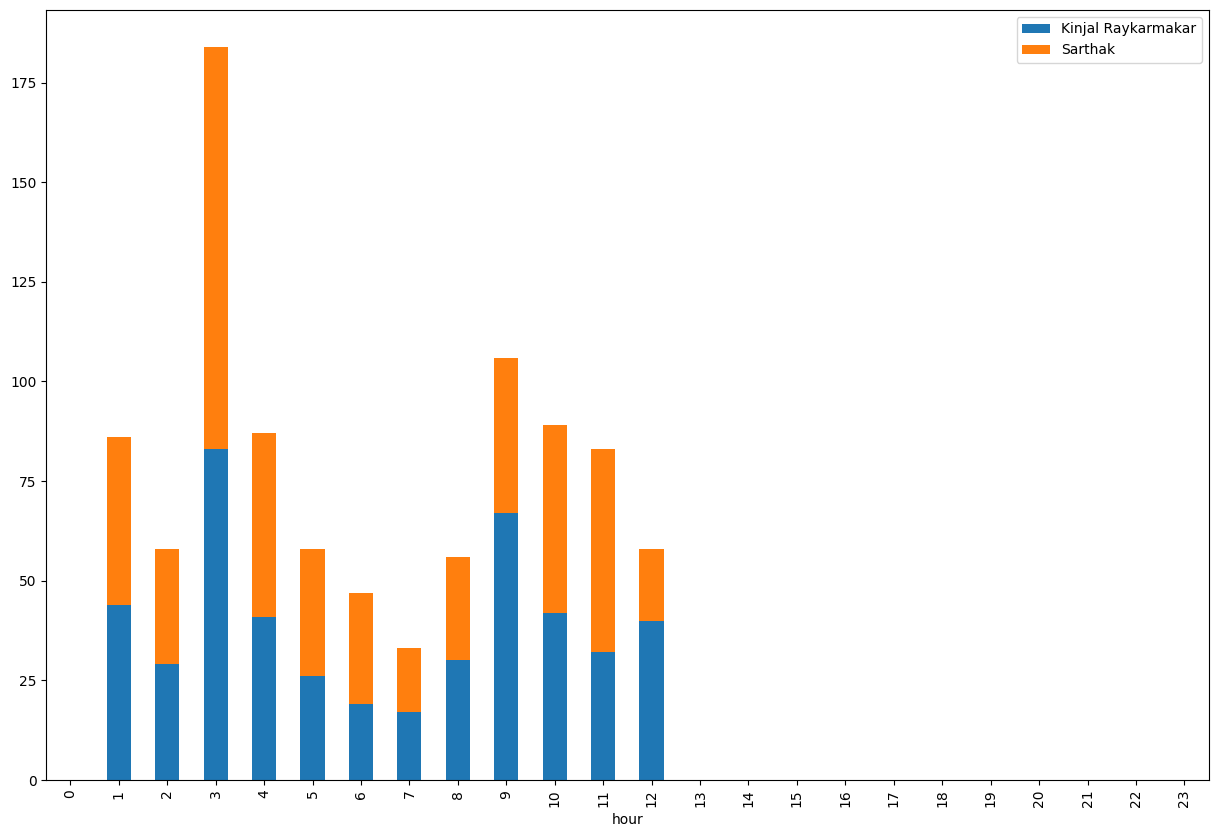

In [242]:
time_count_senderwise_df.plot(x = 'hour', kind = 'bar', stacked=True, figsize = (15, 10))
plt.show()

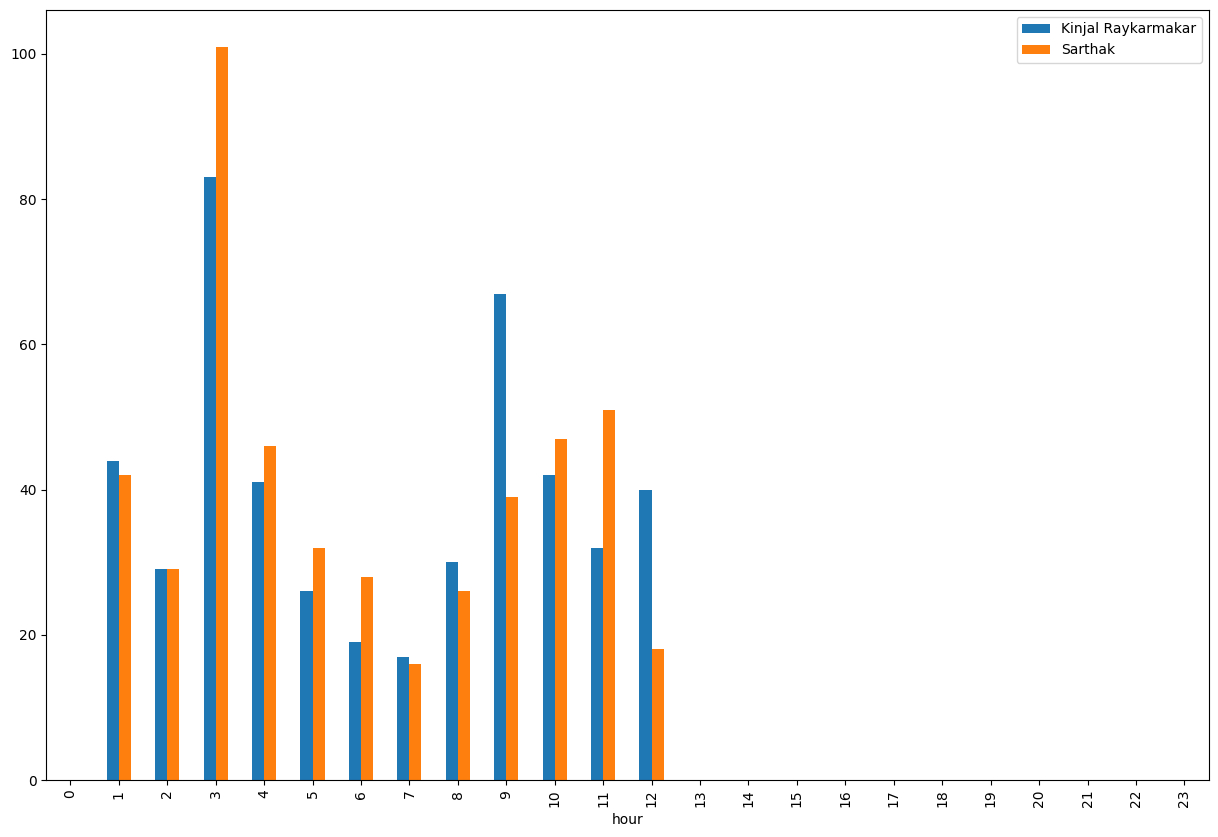

In [243]:
time_count_senderwise_df.plot(x = 'hour', kind = 'bar', figsize = (15, 10))
plt.show()